# 🧪 MRI Preprocessing – 02_preprocessing_mri.ipynb

This notebook performs key preprocessing steps for structural MRI volumes (T1-weighted) as part of a deep learning or neuroimaging pipeline. These steps prepare the raw images for consistent analysis, visualization, or model training.

---

## 🧠 Objectives

- Load and inspect raw MRI images (`.nii.gz`)
- Apply intensity normalization and bias field correction
- Resize volumes to a uniform shape
- Optionally perform skull stripping (if masks available)
- Save preprocessed volumes for downstream use

---

## 📦 Preprocessing Steps

### 1. Load Raw MRI Volumes
Using `nibabel` or `torchio`, we load the 3D T1-weighted brain scans. We visualize axial slices to confirm integrity.

### 2. Intensity Rescaling
MRI images often vary in intensity across subjects or scanners. We apply **intensity normalization** (via `torchio.RescaleIntensity`) to bring values into a consistent range, e.g., [0, 1].

### 3. Bias Field Correction *(optional)*
Bias fields are low-frequency intensity artifacts caused by MRI hardware. If needed, `N4BiasFieldCorrection` from SimpleITK can be integrated, though not used here yet.

### 4. Resizing
We resize all volumes to a common shape (e.g., `256×256×150`) for downstream processing using interpolation.

### 5. Skull Stripping *(optional)*
If brain masks are available, skull stripping can be applied to isolate brain tissue and discard irrelevant structures (e.g., skull, fat).

### 6. Save Processed MRI
Final volumes are saved in `.nii.gz` format using the original affine matrix for anatomical consistency.

---

## 🔧 Tools Used

- `nibabel`: for loading/saving `.nii.gz` volumes
- `torchio`: medical imaging preprocessing (rescaling, transforms)
- `matplotlib`: for visualizing slices of 3D volumes


In [1]:
# Core
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# Preprocessing tools
import torchio as tio  # Excellent for medical imaging
from tqdm import tqdm

# Visualization
from nilearn import plotting  # Optional for advanced visualization

Shape: (256, 256, 150), Data type: float64


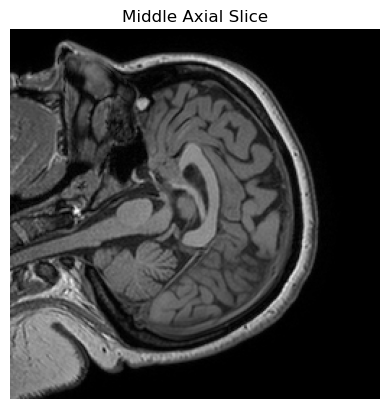

In [3]:
data_path = "../data/100_Guys/T1/NIfTI/IXI100-Guys-0747-T1.nii.gz"
img = nib.load(data_path)
img_data = img.get_fdata()

print(f"Shape: {img_data.shape}, Data type: {img_data.dtype}")

plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
plt.title("Middle Axial Slice")
plt.axis('off')
plt.show()

# Bias Field Correction
Bias field introduces intensity non-uniformity across the image. You can correct this using torchio:

In [4]:
subject = tio.Subject(mri=tio.ScalarImage(data_path))
bias_corrected = tio.transforms.RescaleIntensity()(subject)  # torchio assumes .nii or .nii.gz

corrected_tensor = bias_corrected.mri.data.squeeze().numpy()

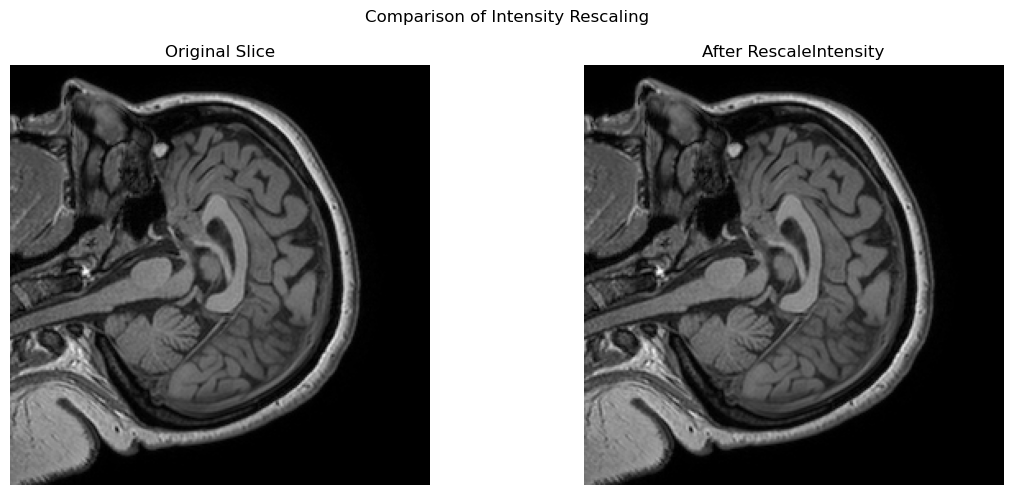

In [5]:
# Load original image
data_path = "../data/100_Guys/T1/NIfTI/IXI100-Guys-0747-T1.nii.gz"
original_img = nib.load(data_path).get_fdata()

# Apply RescaleIntensity from TorchIO
subject = tio.Subject(mri=tio.ScalarImage(data_path))
rescaled_subject = tio.transforms.RescaleIntensity()(subject)
rescaled_img = rescaled_subject.mri.data.squeeze().numpy()

# Choose a slice (e.g., middle axial slice)
z = original_img.shape[2] // 2
original_slice = original_img[:, :, z]
rescaled_slice = rescaled_img[:, :, z]

# Plot side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_slice, cmap='gray')
plt.title("Original Slice")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rescaled_slice, cmap='gray')
plt.title("After RescaleIntensity")
plt.axis('off')

plt.suptitle("Comparison of Intensity Rescaling")
plt.tight_layout()
plt.show()

# Intensity Normalization

In [6]:
def normalize(image):
    return (image - np.mean(image)) / np.std(image)

normalized_img = normalize(corrected_tensor)

# Resampling or Resizing

In [18]:
import torch 

subject = tio.Subject(mri=tio.ScalarImage(tensor=torch.tensor(normalized_img[None])))
resize_transform = tio.Resize((128, 128, 128))  # Or (64, 64, 64) if you're memory-constrained
resized = resize_transform(subject)

resized_img = resized.mri.data.squeeze(0).numpy()
print("New shape:", resized_img.shape)

New shape: (128, 128, 128)


# Skull Stripping / Masking

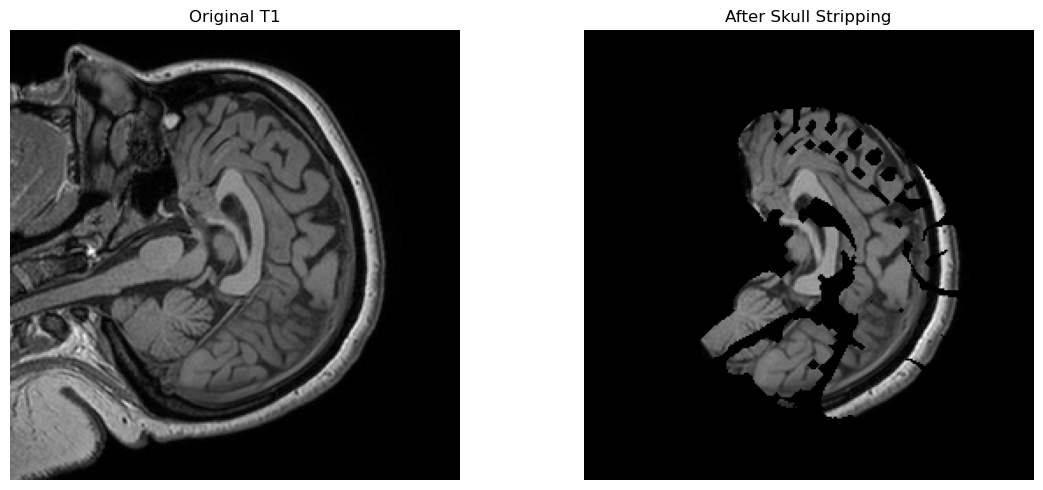

In [9]:
from nilearn.masking import compute_brain_mask
import nibabel as nib
import matplotlib.pyplot as plt

# Load T1 image
t1_img = nib.load('../data/100_Guys/T1/NIfTI/IXI100-Guys-0747-T1.nii.gz')

# Compute a brain mask automatically
mask_img = compute_brain_mask(t1_img)

# Save mask if needed
nib.save(mask_img, 'brain_mask.nii.gz')

# Apply mask
t1_data = t1_img.get_fdata()
mask_data = mask_img.get_fdata()
masked_t1 = t1_data * mask_data  # element-wise masking

# Show mid-slice
z = masked_t1.shape[2] // 2
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(t1_data[:, :, z], cmap='gray')
plt.title("Original T1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_t1[:, :, z], cmap='gray')
plt.title("After Skull Stripping")
plt.axis('off')

plt.tight_layout()
plt.show()

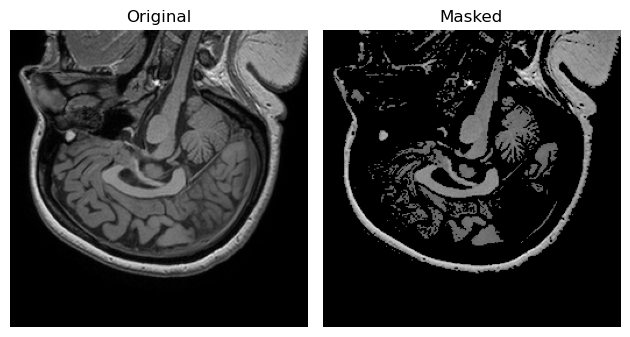

In [16]:
# Use SimpleITK with thresholding (crude, but no extra libraries)
# You could implement a crude intensity-based mask using a threshold on your T1 image:
import SimpleITK as sitk

# Load T1 image
img = sitk.ReadImage('../data/100_Guys/T1/NIfTI/IXI100-Guys-0747-T1.nii.gz')
img_array = sitk.GetArrayFromImage(img)

# Apply threshold (you may need to tune this!)
threshold = img_array > 900
masked_array = img_array * threshold

# Show mid-slice
z = img_array.shape[0] // 2
plt.subplot(1, 2, 1)
plt.imshow(img_array[z], cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(masked_array[z], cmap="gray")
plt.title("Masked")
plt.axis("off")
plt.tight_layout()
plt.show()

# Save the Preprocessed Volume

In [17]:
output_path = "../data/preprocessed/100_Guys_preprocessed.nii.gz"
nib.save(nib.Nifti1Image(resized_img, affine=img.affine), output_path)

AttributeError: 'Image' object has no attribute 'affine'